# Môn học: Lập trình song song trên GPU
---
## Thuật toán: SEAM CARVING

## Thành viên:
- Phạm Quang Trung
- Bùi Văn Sơn

# Table of contents

0. Giới thiệu
1. Ý tưởng chính
2. Chuyển ảnh từ RGB sang Grayscale
3. Convolution
4. Tính năng lượng trên mỗi pixel using _gradient magnitude_
5. Tìm seam có năng lượng thấp
6. Xóa đường seam có năng lượng thấp
7. Demo
8. Tham khảo

# 0/ Giới thiệu

__Seam carving__ là một thuật toán thay đổi kích thước ảnh một cách tự nhiên và không làm biến dạng hình ảnh. Thuật toán này được giới thiệu bởi Shai Avidan và Ariel Shamir vào năm 2007 và đã được sử dụng trong nhiều ứng dụng như cắt ảnh, điều chỉnh kích thước ảnh cho các thiết bị di động, hay thậm chí giúp tăng tốc độ tải trang web.

Thuật toán Seam carving chủ yếu sử dụng trong việc giảm kích thước ảnh mà không làm biến dạng hình ảnh. Nó thực hiện việc xác định các pixel không quan trọng trong ảnh và loại bỏ chúng đi. Việc loại bỏ các pixel này được thực hiện bằng cách tìm kiếm một "seam" (đường dọc hoặc ngang) trong ảnh, đường này đi qua các pixel có độ tương phản thấp nhất. Các seam này có thể được xóa một cách an toàn vì chúng không làm thay đổi ý nghĩa của hình ảnh.

## Trước

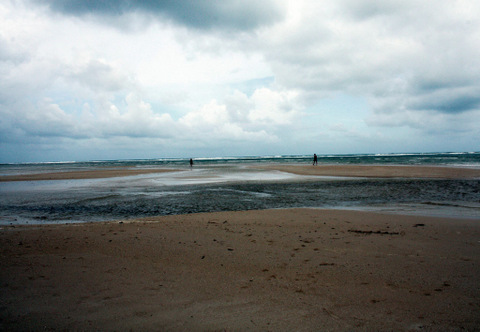

## Sau

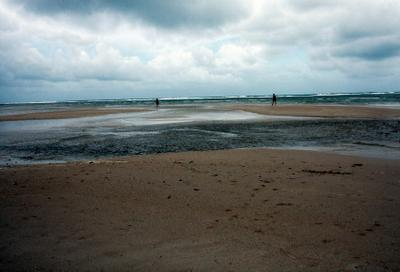

# 1/ Ý tưởng chính

Thuật toán Seam carving được thực hiện trên GPU như sau:

1.   Đọc hình ảnh và xác định kích thước mới cho hình ảnh đầu ra.
2.   Tính toán ma trận năng lượng của ảnh.
  - Trước đó ảnh phải được chuyển sang Grayscale
3.   Tính toán ma trận seam của ảnh.
4.   Xác định seam cần loại bỏ và xóa seam khỏi ảnh.
5.   Lặp lại bước 2 đến bước 5 đến khi ảnh đạt được kích thước mong muốn


Lưu ý:
- Hàm quan trọng trong thuật toán Seam carving là hàm tính toán năng lượng của mỗi pixel trong ảnh. Năng lượng này được sử dụng để tìm kiếm seam có độ tương phản thấp nhất trong ảnh(Hàm tính toán năng lượng của mỗi pixel có thể được song song hóa bằng cách chia ảnh thành các khối và tính toán năng lượng của từng khối bằng các thread trên GPU).

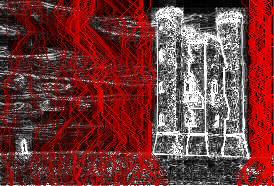

# 2/ Chuyển ảnh từ RGB sang Grayscale

- Công thức: gray = 0.299 * red + 0.587 * green + 0.114 * blue
- Chuyển ảnh từ màu RGB sang GrayScale để giảm chiều dữ liệu và tính toán năng lượng hiệu quả hơn
- Phương pháp áp dụng: Phương pháp trọng số là tính trọng số trung bình của các kênh màu

# 3/ Convolution

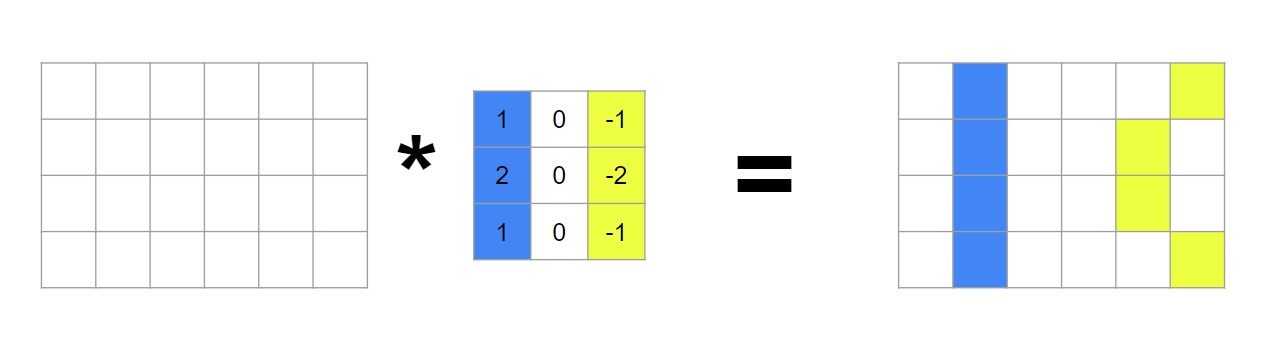

Convolution trong seam carving là một kỹ thuật xử lý ảnh được sử dụng để tính toán năng lượng của các pixel trong ảnh. Kỹ thuật này sử dụng một ma trận gọi là kernel hoặc filter để thực hiện phép tính convolution trên từng pixel của ảnh

Kernel là một ma trận vuông với kích thước lẻ và chứa các giá trị số thực. Convolution được thực hiện bằng cách di chuyển kernel trên ảnh và tính tích chập (dot product) giữa kernel và một phần của ảnh tại mỗi vị trí. Tổng kết quả được gán cho pixel tại vị trí tương ứng trên ảnh.

Trong trường hợp xác định cạnh dọc của ảnh, ta sử dụng kernel x-Sobel. Kernel này có dạng như sau:
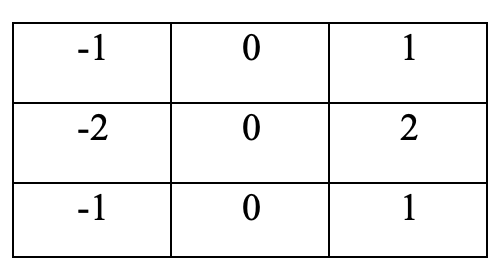

Ta thực hiện phép tính convolution giữa kernel này và từng vùng pixel của ảnh đầu vào. Quá trình tính toán convolution được thực hiện như sau:

Di chuyển kernel trên khắp ảnh, tính toán tích chập giữa kernel và từng vùng 3x3 của ảnh.
Tính tổng trọng số của tích chập, sử dụng để tính giá trị mới cho pixel tại vị trí tương ứng trên ảnh mới.
Ví dụ, giả sử ta có ảnh đầu vào sau đây:
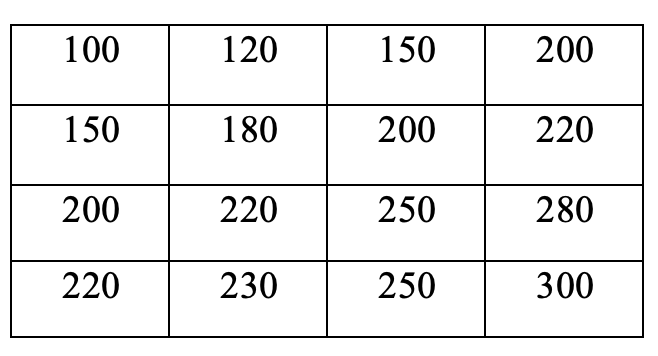

Ta sẽ thực hiện phép tính convolution giữa kernel x-Sobel và từng vùng 3x3 của ảnh đầu vào, lần lượt cho từng pixel trên ảnh mới:

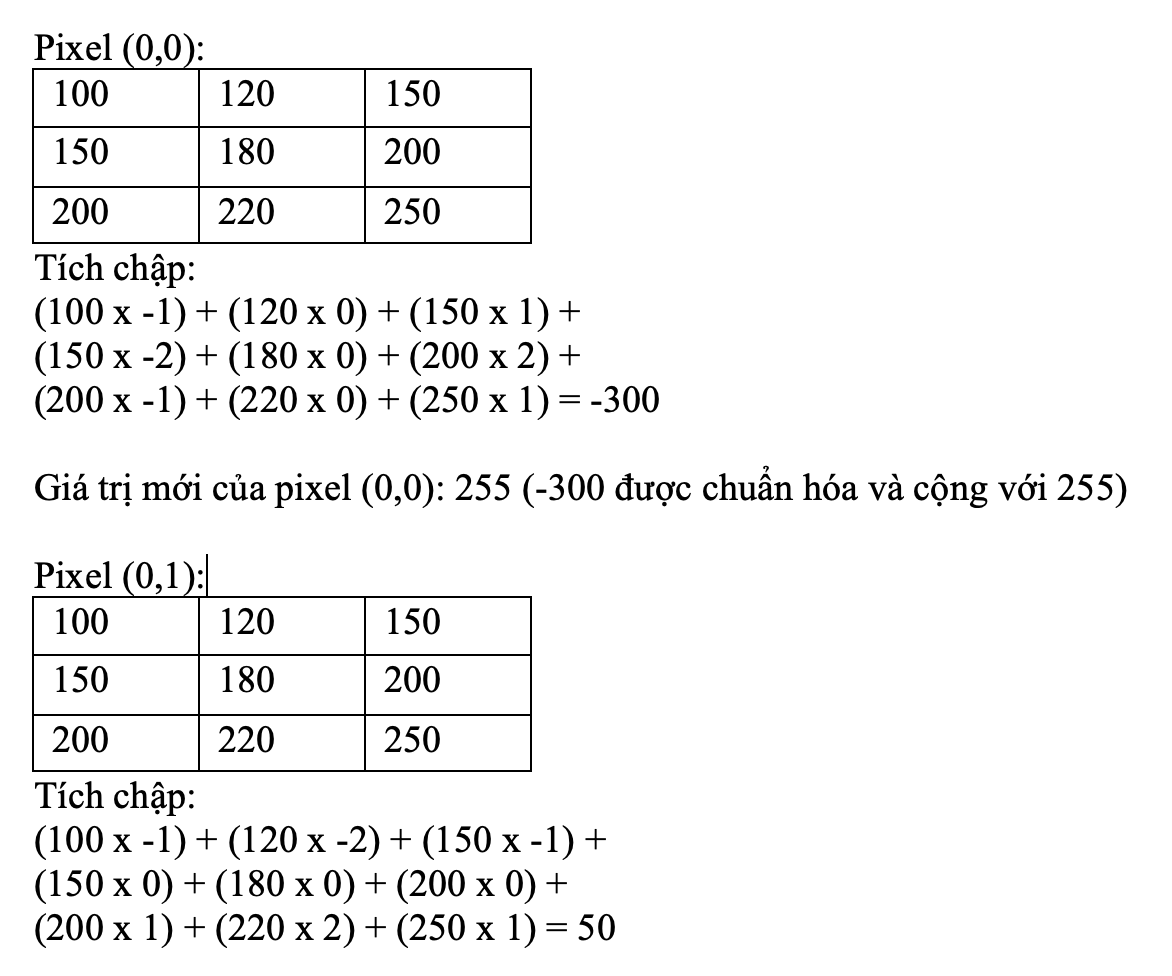

## Ví dụ: Convolution giữa ảnh grayscale với x-Sobel kernel


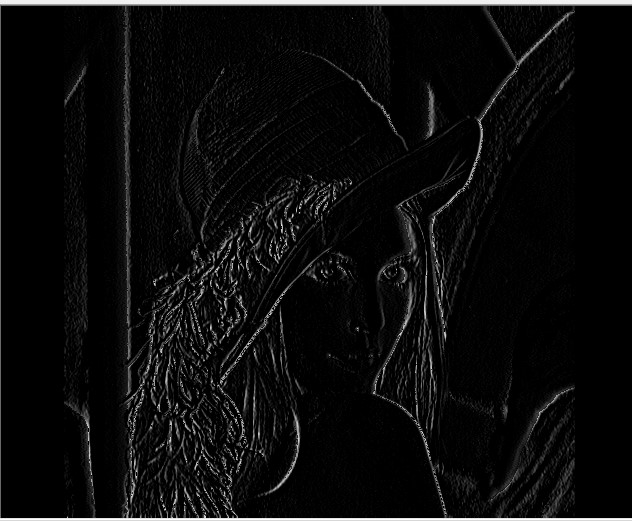

# 4/ Calculate the energy of each pixels using gradient magnitude

## Calculate from the bottom

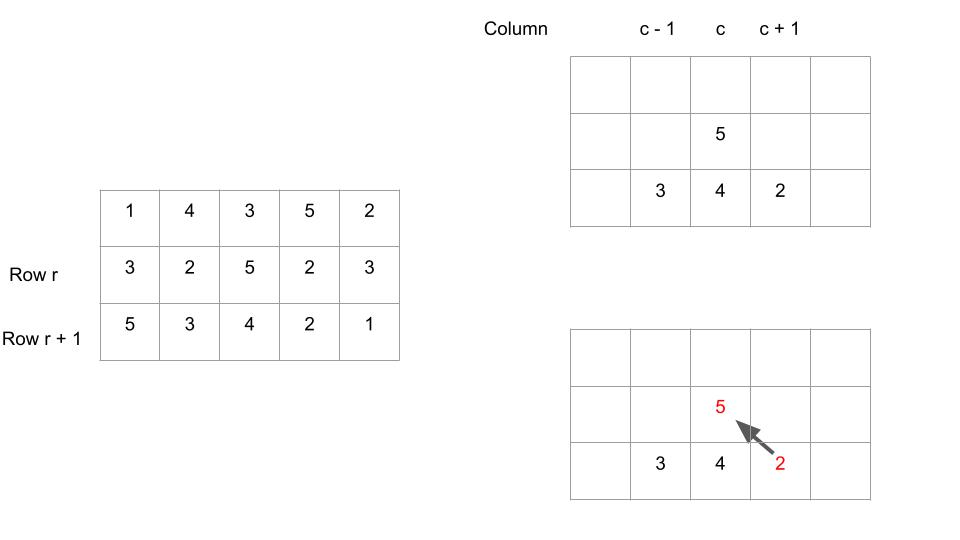

## Ý tưởng:
- Xét từng dòng từ dưới lên (trừ dòng cuối cùng "r + 1")
- Giá trị của ô được cộng từ phần tử nhỏ nhất trong 3 ô ngay bên dưới
- Nếu ô đang xét là cạnh thì chỉ có 2 ô bên dưới nó

## Note:
Before we begin the work of deleting a seam, we must recalculate this entire significance. Suppose, to delete 100 seam, all 100 degree tables will be created.

## Nhược điểm:
Trong ứng dụng ngoài đời thực, khi chúng ta muốn kéo thả cửa sổ ứng dụng để thu nhỏ ảnh thì sẽ mất một khoảng thời gian nhất định để cho ra ảnh hoàn chỉnh, thay vì kéo đến đâu thì ảnh thu nhỏ đến đó.

## Cách fix:
Chỉ cập nhật các Pixel nằm bên cạnh đường seam đã xóa

## Tính toán sử dụng device

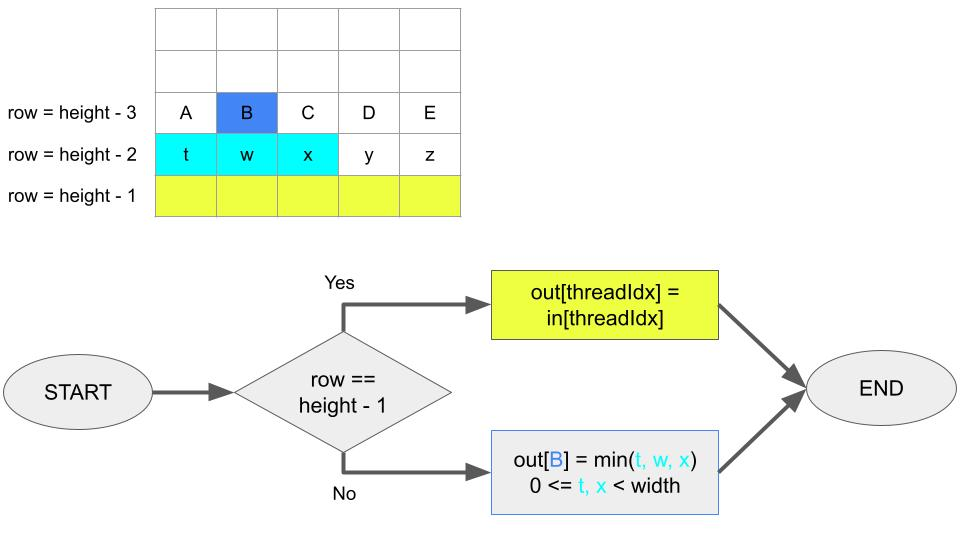

- Chúng tôi sẽ kết hợp sử dụng host và device để xử lý vấn đề trên:
    - Host: Chạy vòng lặp xử lý mỗi dòng 1 lần, bắt đầu từ dòng dưới cùng.
    - Device: Đưa hàm toàn cục vào vòng lặp để xử lý

- Mỗi vòng lặp sẽ xử lý thành công 1 dòng thì lại xảy ra vấn đề mới: không thể khai báo số luồng với cả 1 ảnh vì chỉ xử lý theo dòng: 1 dòng cho dòng cuối cùng (dòng màu vàng, hình trên), và 2 lines cho các dòng còn lại (hình dưới).

- After the device completes, that is, the end of a loop, it will be the host's turn to execute the next line, which needs to be synchronized immediately.
- Sau khi device hoàn thành, tức là kết thúc một vòng lặp, sẽ đến lượt host thực hiện dòng tiếp theo cần được đồng bộ hóa ngay lập tức.

- Nhảy đến vòng for của host

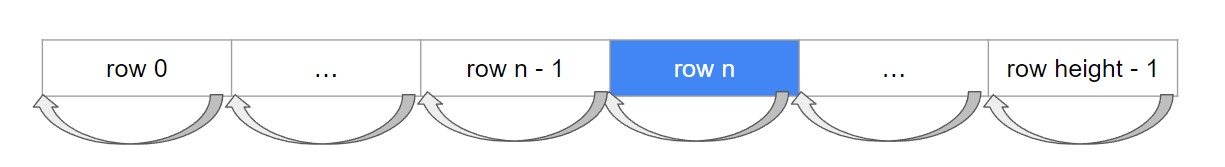

# 5/ Tìm đường năng lượng seams

The group have not yet coded the solution for device. Therefore, we are going to reuse host function.

Hình bên dưới: bên trái là ý nghĩa đối với đáy (năng lượng tối thiểu đến cuối) và bên phải là mảng 1 chiều được đánh dấu (màu xanh lam) đường nối nhỏ nhất.
- Go against the step of calculating the importance.
- Vị trí thứ __i__ trong mảng bên phải là dòng thứ i

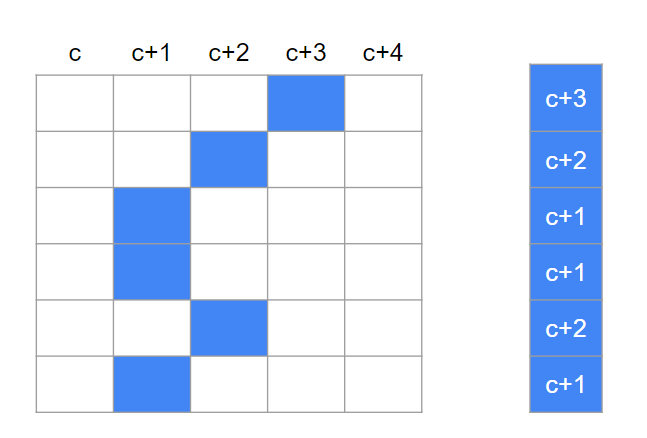

- Hàng đầu tiên: tìm giá trị nhỏ nhất của hàng
- Hàng tiếp theo: lấy vị trí cột của "giá trị nhỏ nhất của hàng đầu tiên" (c+3)
     - Lấy 3 giá trị của: (c+3)-1; (c+3); (c+3)+1; lấy giá trị nhỏ nhất là (c+3)-1 = c+2. Lưu vào mảng bên phải.
     - Tiếp tục đi cho đến khi đến hàng cuối cùng.

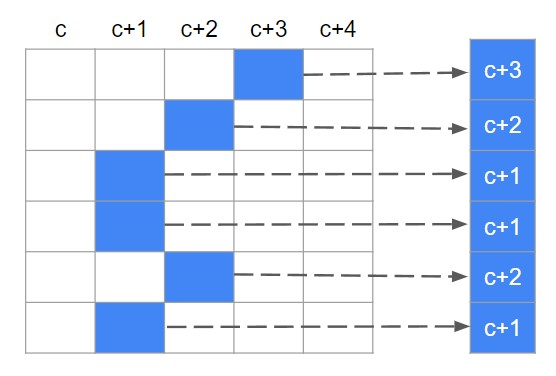

# 6/ Xóa seams có năng lượng thấp

## Host:
Output sẽ thêm từng phần tử từ RGB, nếu phần tử này được đánh dấu thì bỏ qua. Cứ như vậy đi đến cuối mảng.

Ta sẽ chứng minh ngay trên mảng 2 chiều năng lượng cho đến hết. (thực ra chúng ta sẽ chạy trên ảnh RGB)

### Psedocode: 
```cpp
for (int i = 0; i < width * heigth; i++) 
{
    if is_marked( input[i] ):
        continue;
    out.add( input[i] )
}
```

## Device: 
- Đối với mỗi hàng, ví dụ hàng thứ r (ví dụ: r=1), các phần tử trước ô màu xanh sẽ dịch sang trái r (r=1) đơn vị, ô màu xanh không được xử lý, các ô màu xanh sau sẽ dịch sang phải r + 1 (r+1 = 1+1 = 2) đơn vị.

### General: 
dòng thứ r: các phần tử trước ô bị xóa, di chuyển sang trái r đơn vị; các ô đã xóa không được xem xét; ô sau ô bị xóa di chuyển sang trái r+1 đơn vị



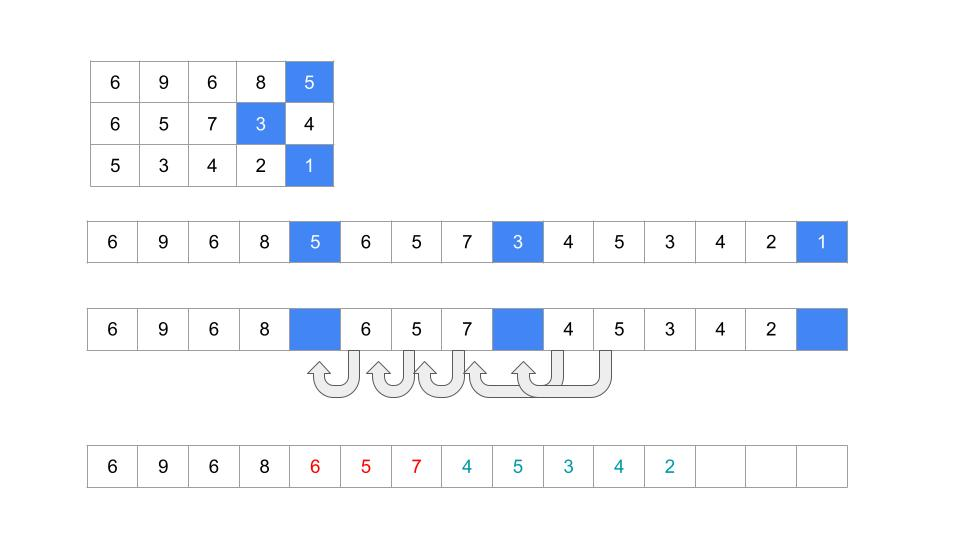

# 7/ Demo

In [ ]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git

In [ ]:
%load_ext nvcc_plugin

In [ ]:
%reload_ext nvcc_plugin

In [ ]:
!git clone https://github.com/son-bui/seam-carving-12.git
%cd ./seam-carving-12/

In [ ]:

from PIL import Image
import numpy as np
def show_pnm(file_name):
    with open(file_name, 'r') as f:
        vals = f.read().split()
        w = int(vals[1])
        h = int(vals[2])
        if vals[0] == 'P2': # Grayscale
            pixels = np.array(vals[4:], dtype=np.uint8).reshape((h, w))
        elif vals[0] == 'P3': # RGB
            pixels = np.array(vals[4:], dtype=np.uint8).reshape((h, w, 3))
        else:
            return None

    return Image.fromarray(pixels)

def show_matrix(matrix_file):
    '''
    input: filename
    output: show matrix

    Each element on the same line is sperated by a space
    '''
    m = np.loadtxt(matrix_file)
    m = m + m.min()
    m = m / m.max()
    m = m * 255
    m = m.astype(np.uint8)
    return Image.fromarray(m)

In [ ]:
!nvcc -rdc=true ./main.cu ./src/*/* -o ./result/exe/seamCarving

In [ ]:
!./result/exe/seamCarving ./images/broadcast_tower.pnm ./result/broadcast_tower 150

In [ ]:
show_pnm('./images/broadcast_tower.pnm')

In [ ]:
show_pnm('./result/broadcast_tower_host.pnm')

# 8/ References

[Slides from teacher Phạm Trọng Nghĩa]("https://drive.google.com/drive/folders/19_KM-2h6aa5OE8wDsM6kk5THcPHfKLjS" "Drive")

[Wikipedia - Seam Carving]("https://en.wikipedia.org/wiki/Seam_carving" "wikipedia")

[18.S191 MIT Fall 2020 - Seam Carving - Grant Sanderson]("https://www.youtube.com/watch?v=rpB6zQNsbQU" "youtube")

[MIT 18.S191 Fall 2020 - Seam Carving - James Schloss]("https://www.youtube.com/watch?v=ALcohd1q3dk" "youtube")

[Convolution - 3Blue1Brown - Grant Sanderson]("https://www.youtube.com/watch?v=KuXjwB4LzSA" "youtube")